In [1]:
#Find best parameters for NN model and evaluate on Test set = 0.2 * total years
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
import warnings

warnings.filterwarnings("ignore")

# ── Config ─────────────────────────────────────────────────────────────────────
SAMPLE_FACTOR = 1
TEST_YEARS    = 11
TRAIN_YEARS   = 45   # 0.8 training / 0.2 testing split
RESPONSE_VAR  = "TMAX"
LOOKBACK      = 30   # days of history used for each prediction

# ── Load & Preprocess ───────────────────────────────────────────────────────────
df = pd.read_csv("Miami.csv", index_col="DATE", parse_dates=True)
df = df.select_dtypes(include="number")
df["PRCP"].fillna(0, inplace=True)
df.interpolate(method="linear", inplace=True)

# cyclicals
df["month"]       = df.index.month
df["day_of_year"] = df.index.dayofyear
df["sin_month"]   = np.sin(2*np.pi * df["month"]/12)
df["cos_month"]   = np.cos(2*np.pi * df["month"]/12)
df["sin_day"]     = np.sin(2*np.pi * df["day_of_year"]/365)
df["cos_day"]     = np.cos(2*np.pi * df["day_of_year"]/365)

# ── Train/Test Split ────────────────────────────────────────────────────────────
sampled = df.iloc[::SAMPLE_FACTOR]
n_train = int(TRAIN_YEARS * 365 / SAMPLE_FACTOR)
n_test  = int(TEST_YEARS  * 365 / SAMPLE_FACTOR)

train_df = sampled.iloc[:n_train]
test_df  = sampled.iloc[n_train:n_train + n_test]

# ── Scale FEATURES ──────────────────────────────────────────────────────────────
date_feats     = ["sin_month","cos_month","sin_day","cos_day"]
feature_cols   = [RESPONSE_VAR] + date_feats

scaler      = MinMaxScaler()
train_vals  = scaler.fit_transform(train_df[feature_cols])
test_vals   = scaler.transform(test_df[feature_cols])
test_date_feats = test_vals[:, 1:]   # for the recursive loop

# ── Sequence Builder ─────────────────────────────────────────────────────────────
def build_sequences(values, lookback):
    X, y = [], []
    for i in range(len(values) - lookback):
        X.append(values[i : i+lookback].flatten())
        y.append(values[i+lookback, 0])
    return np.array(X), np.array(y)

X_train, y_train = build_sequences(train_vals, LOOKBACK)

# ── Hyperparameter grid ─────────────────────────────────────────────────────────
param_grid = {
    "hidden_layer_sizes": [(256,128), (128,64,32)],
    "alpha": [1e-4, 1e-3, 1e-2],
    "learning_rate_init": [1e-3, 5e-4, 1e-4],
}

results = []

# ── Grid search (manual) ─────────────────────────────────────────────────────────
for hidden in param_grid["hidden_layer_sizes"]:
    for alpha in param_grid["alpha"]:
        for lr in param_grid["learning_rate_init"]:
            mdl = MLPRegressor(
                hidden_layer_sizes=hidden,
                activation="relu",
                solver="adam",
                alpha=alpha,
                learning_rate_init=lr,
                max_iter=5000,
                early_stopping=True,
                validation_fraction=0.1,
                n_iter_no_change=20,
                random_state=42,
                verbose=False
            )
            mdl.fit(X_train, y_train)

            # ── Recursive multi-step forecast ────────────────────────────
            last_window = train_vals[-LOOKBACK:].copy()
            preds_scaled = []
            for i in range(len(test_df)):
                inp = last_window.flatten().reshape(1, -1)
                p   = mdl.predict(inp)[0]
                preds_scaled.append(p)
                nxt = np.concatenate([[p], test_date_feats[i]])
                last_window = np.vstack([last_window[1:], nxt])

            full_pred_scaled = np.hstack([
                np.array(preds_scaled).reshape(-1,1),
                test_date_feats
            ])
            full_pred = scaler.inverse_transform(full_pred_scaled)
            preds = full_pred[:, 0]

            mae = mean_absolute_error(test_df[RESPONSE_VAR], preds)
            print(f"hidden={hidden}, alpha={alpha:.0e}, lr={lr:.0e} → MAE={mae:.4f}")
            results.append({
                "hidden": hidden,
                "alpha": alpha,
                "lr": lr,
                "mae": mae
            })

# ── Pick best ────────────────────────────────────────────────────────────────────
best = min(results, key=lambda x: x["mae"])
print("\nBest parameters:")
print(f" hidden_layer_sizes = {best['hidden']}")
print(f" alpha              = {best['alpha']}")
print(f" learning_rate_init = {best['lr']}")
print(f" MAE                = {best['mae']:.4f}")

# ── Retrain & Plot final model ───────────────────────────────────────────────────
best_mdl = MLPRegressor(
    hidden_layer_sizes=best["hidden"],
    activation="relu",
    solver="adam",
    alpha=best["alpha"],
    learning_rate_init=best["lr"],
    max_iter=5000,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=42,
    verbose=False
)
best_mdl.fit(X_train, y_train)

last_window = train_vals[-LOOKBACK:].copy()
preds_scaled = []
for i in range(len(test_df)):
    inp = last_window.flatten().reshape(1, -1)
    p   = best_mdl.predict(inp)[0]
    preds_scaled.append(p)
    nxt = np.concatenate([[p], test_date_feats[i]])
    last_window = np.vstack([last_window[1:], nxt])

full_pred_scaled = np.hstack([
    np.array(preds_scaled).reshape(-1,1),
    test_date_feats
])
full_pred = scaler.inverse_transform(full_pred_scaled)
preds = full_pred[:, 0]
pred_series = pd.Series(preds, index=test_df.index)

mae_final = mean_absolute_error(test_df[RESPONSE_VAR], pred_series)
print(f"\nFinal best-model MAE on hold-out: {mae_final:.4f}°F")

plt.figure(figsize=(14,7))
plt.plot(train_df[RESPONSE_VAR], color="lightgray", label="Train history")
plt.plot(test_df[RESPONSE_VAR],  color="green",     label="Actual hold-out")
plt.plot(pred_series,             color="crimson",   linestyle="--", label="Best forecast")
plt.title(f"{RESPONSE_VAR} Forecast (best model)")
plt.xlabel("Date"); plt.ylabel("Temperature (°F)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'Miami.csv'

Training on entire dataset…


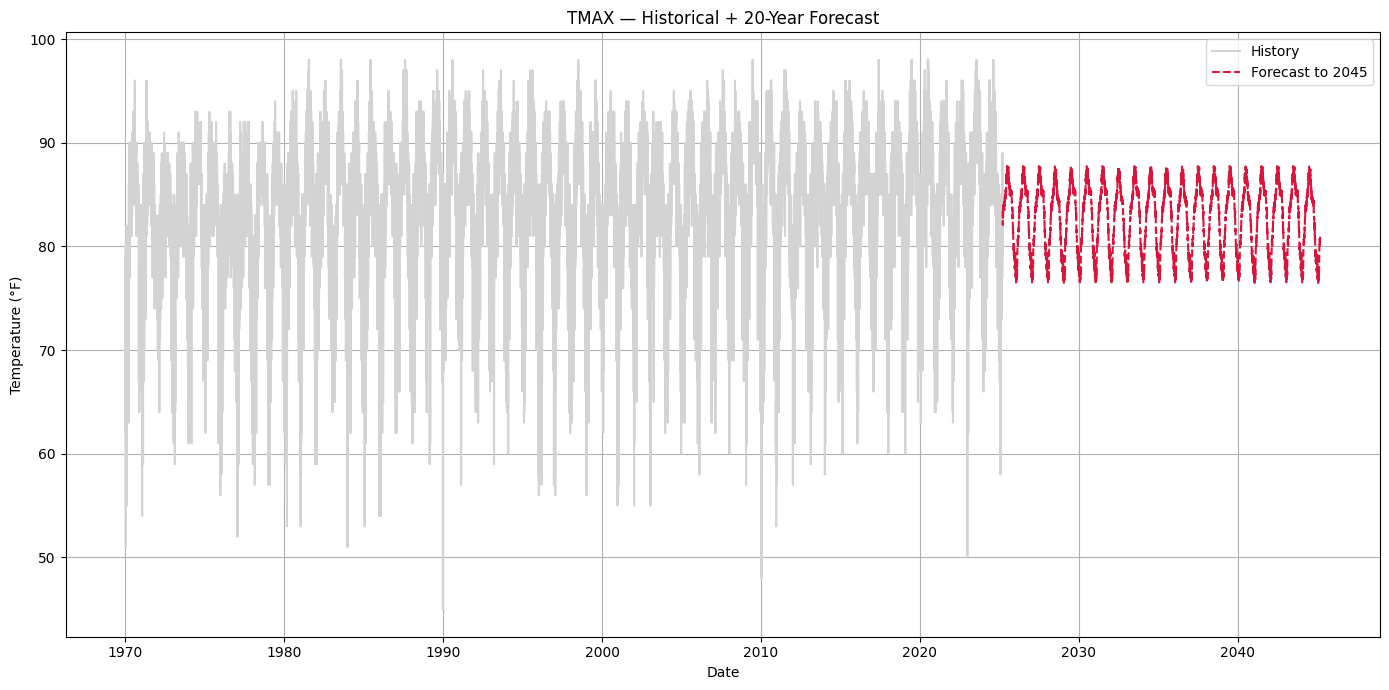

In [30]:
#Retrain on entire model, and predict 20 years into the future using best parameters from before.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
import warnings

warnings.filterwarnings("ignore")

# ── Config ─────────────────────────────────────────────────────────────────────
FUTURE_YEARS  = 20   # years to forecast into the future
RESPONSE_VAR  = "TMAX"
LOOKBACK      = 30   # days of history used for each prediction

# ── Load & Preprocess ───────────────────────────────────────────────────────────
df = pd.read_csv("Miami.csv", index_col="DATE", parse_dates=True)
df = df.select_dtypes(include="number")
df["PRCP"].fillna(0, inplace=True)
df.interpolate(method="linear", inplace=True)

# cyclicals
df["month"]       = df.index.month
df["day_of_year"] = df.index.dayofyear
df["sin_month"]   = np.sin(2*np.pi * df["month"]/12)
df["cos_month"]   = np.cos(2*np.pi * df["month"]/12)
df["sin_day"]     = np.sin(2*np.pi * df["day_of_year"]/365)
df["cos_day"]     = np.cos(2*np.pi * df["day_of_year"]/365)

# ── Scale FEATURES ──────────────────────────────────────────────────────────────
date_feats   = ["sin_month","cos_month","sin_day","cos_day"]
feature_cols = [RESPONSE_VAR] + date_feats

scaler      = MinMaxScaler()
all_vals    = scaler.fit_transform(df[feature_cols])
train_vals  = all_vals  # we train on entire dataset

# ── Sequence Builder ─────────────────────────────────────────────────────────────
def build_sequences(values, lookback):
    X, y = [], []
    for i in range(len(values) - lookback):
        X.append(values[i : i+lookback].flatten())
        y.append(values[i+lookback, 0])
    return np.array(X), np.array(y)

X_train, y_train = build_sequences(train_vals, LOOKBACK)

# ── Train best‐param MLP on full data ────────────────────────────────────────────
model = MLPRegressor(
    hidden_layer_sizes=(best['hidden']),
    activation="relu",
    solver="adam",
    alpha=best['alpha'],
    learning_rate_init=best['lr'],
    max_iter=5000,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=42,
    verbose=False
)
print("Training on entire dataset…")
model.fit(X_train, y_train)

# ── Build future date features ──────────────────────────────────────────────────
last_date    = df.index.max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                             periods=FUTURE_YEARS * 365,
                             freq='D')
future_df = pd.DataFrame(index=future_dates)
future_df["month"]       = future_df.index.month
future_df["day_of_year"] = future_df.index.dayofyear
future_df["sin_month"]   = np.sin(2*np.pi * future_df["month"]/12)
future_df["cos_month"]   = np.cos(2*np.pi * future_df["month"]/12)
future_df["sin_day"]     = np.sin(2*np.pi * future_df["day_of_year"]/365)
future_df["cos_day"]     = np.cos(2*np.pi * future_df["day_of_year"]/365)

# scale future date features (prepend dummy TMAX column)
dummy_tmax = np.zeros(len(future_df))
future_vals = scaler.transform(
    np.hstack([
        dummy_tmax.reshape(-1,1),
        future_df[date_feats].values
    ])
)
future_date_feats = future_vals[:, 1:]  # shape (n_future, 4)

# ── Recursive multi-step forecast into the future ───────────────────────────────
last_window  = train_vals[-LOOKBACK:].copy()
preds_scaled = []
for i in range(len(future_df)):
    inp  = last_window.flatten().reshape(1, -1)
    p    = model.predict(inp)[0]
    preds_scaled.append(p)
    nxt  = np.concatenate([[p], future_date_feats[i]])
    last_window = np.vstack([last_window[1:], nxt])

# invert scaling
full_pred_scaled = np.hstack([
    np.array(preds_scaled).reshape(-1,1),
    future_date_feats
])
full_pred   = scaler.inverse_transform(full_pred_scaled)
preds       = full_pred[:, 0]
pred_series = pd.Series(preds, index=future_dates)

# ── Plot history + forecast ─────────────────────────────────────────────────────
plt.figure(figsize=(14,7))
plt.plot(df[RESPONSE_VAR],  color="lightgray", label="History")
plt.plot(pred_series,       color="crimson",   linestyle="--", label="Forecast to 2045")
plt.title(f"{RESPONSE_VAR} — Historical + {FUTURE_YEARS}-Year Forecast")
plt.xlabel("Date")
plt.ylabel("Temperature (°F)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
# Save predictions to CSV
predictions_df = pd.DataFrame({
    'Date': pred_series.index,
    'Predicted_TMAX': pred_series.values
})
predictions_df.to_csv("NN_Predictions.csv", index=False)

print("Predictions saved to NN_Predictions.csv")


Predictions saved to NN_Predictions.csv
